<a href="https://www.kaggle.com/code/brmil07/image-classification-with-tensorflow?scriptVersionId=162446893" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Image Classification with Convolutional Neural Network 🖼️**
---
This dataset contains image data of Natural Scenes around the world.

**Content** \
This Data contains around 25k images of size 150x150 distributed under 6 categories:
* 'buildings' -> 0
* 'forest' -> 1
* 'glacier' -> 2
* 'mountain' -> 3
* 'sea' -> 4
* 'street' -> 5 

The Train, Test and Prediction data is separated in each zip files. There are around 14k images in Train, 3k in Test and 7k in Prediction.
This data was initially published on [Analytics Vidhya](https://datahack.analyticsvidhya.com) by Intel to host a Image classification Challenge.

More info on dataset: [intel image classification](https://www.kaggle.com/datasets/puneet6060/intel-image-classification/data)

## **Import the Libraries 📚**
---

In [1]:
import numpy as np
import pandas as pd
import os
import warnings
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix

In [2]:
#Make sure Tensorflow is version 2.0 or higher
print('Tensorflow Version:', tf.__version__)

Tensorflow Version: 2.13.0


# **Inspect the Dataset 🔍**
---

In [3]:
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

In [4]:
class_names_label

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [5]:
def load_images(directory, num_files=5):
    images = []
    file_list = os.listdir(directory)[:num_files]  # Load only the first 5 files

    for filename in tqdm(file_list, desc=f"Loading images from {directory}"):
        img_path = os.path.join(directory, filename)
        img = Image.open(img_path)
        img = img.resize((150, 150))  # Resize image to 150 x 150
        images.append(img)

    return images

In [6]:
# Paths to different image categories
buildings_train_dir = '/kaggle/input/intel-image-classification/seg_train/seg_train/buildings'
forest_train_dir = '/kaggle/input/intel-image-classification/seg_train/seg_train/forest'
glacier_train_dir = '/kaggle/input/intel-image-classification/seg_train/seg_train/glacier'
mountain_train_dir = '/kaggle/input/intel-image-classification/seg_train/seg_train/mountain'
sea_train_dir = '/kaggle/input/intel-image-classification/seg_train/seg_train/sea'
street_train_dir = '/kaggle/input/intel-image-classification/seg_train/seg_train/street'

buildings_test_dir = '/kaggle/input/intel-image-classification/seg_test/seg_test/buildings'
forest_test_dir = '/kaggle/input/intel-image-classification/seg_test/seg_test/forest'
glacier_test_dir = '/kaggle/input/intel-image-classification/seg_test/seg_test/glacier'
mountain_test_dir = '/kaggle/input/intel-image-classification/seg_test/seg_test/mountain'
sea_test_dir = '/kaggle/input/intel-image-classification/seg_test/seg_test/sea'
street_test_dir = '/kaggle/input/intel-image-classification/seg_test/seg_test/street'

pred_dir = '/kaggle/input/intel-image-classification/seg_pred/seg_pred'

In [7]:
# Load images from each category
buildings_img = load_images(buildings_train_dir)
forest_img = load_images(forest_train_dir)
glacier_img = load_images(glacier_train_dir)
mountain_img = load_images(mountain_train_dir)
sea_img = load_images(sea_train_dir)
street_img = load_images(street_train_dir)

Loading images from /kaggle/input/intel-image-classification/seg_train/seg_train/buildings: 100%|██████████| 5/5 [00:00<00:00, 181.41it/s]
Loading images from /kaggle/input/intel-image-classification/seg_train/seg_train/forest: 100%|██████████| 5/5 [00:00<00:00, 265.09it/s]
Loading images from /kaggle/input/intel-image-classification/seg_train/seg_train/glacier: 100%|██████████| 5/5 [00:00<00:00, 280.78it/s]
Loading images from /kaggle/input/intel-image-classification/seg_train/seg_train/mountain: 100%|██████████| 5/5 [00:00<00:00, 293.58it/s]
Loading images from /kaggle/input/intel-image-classification/seg_train/seg_train/sea: 100%|██████████| 5/5 [00:00<00:00, 281.30it/s]
Loading images from /kaggle/input/intel-image-classification/seg_train/seg_train/street: 100%|██████████| 5/5 [00:00<00:00, 295.19it/s]


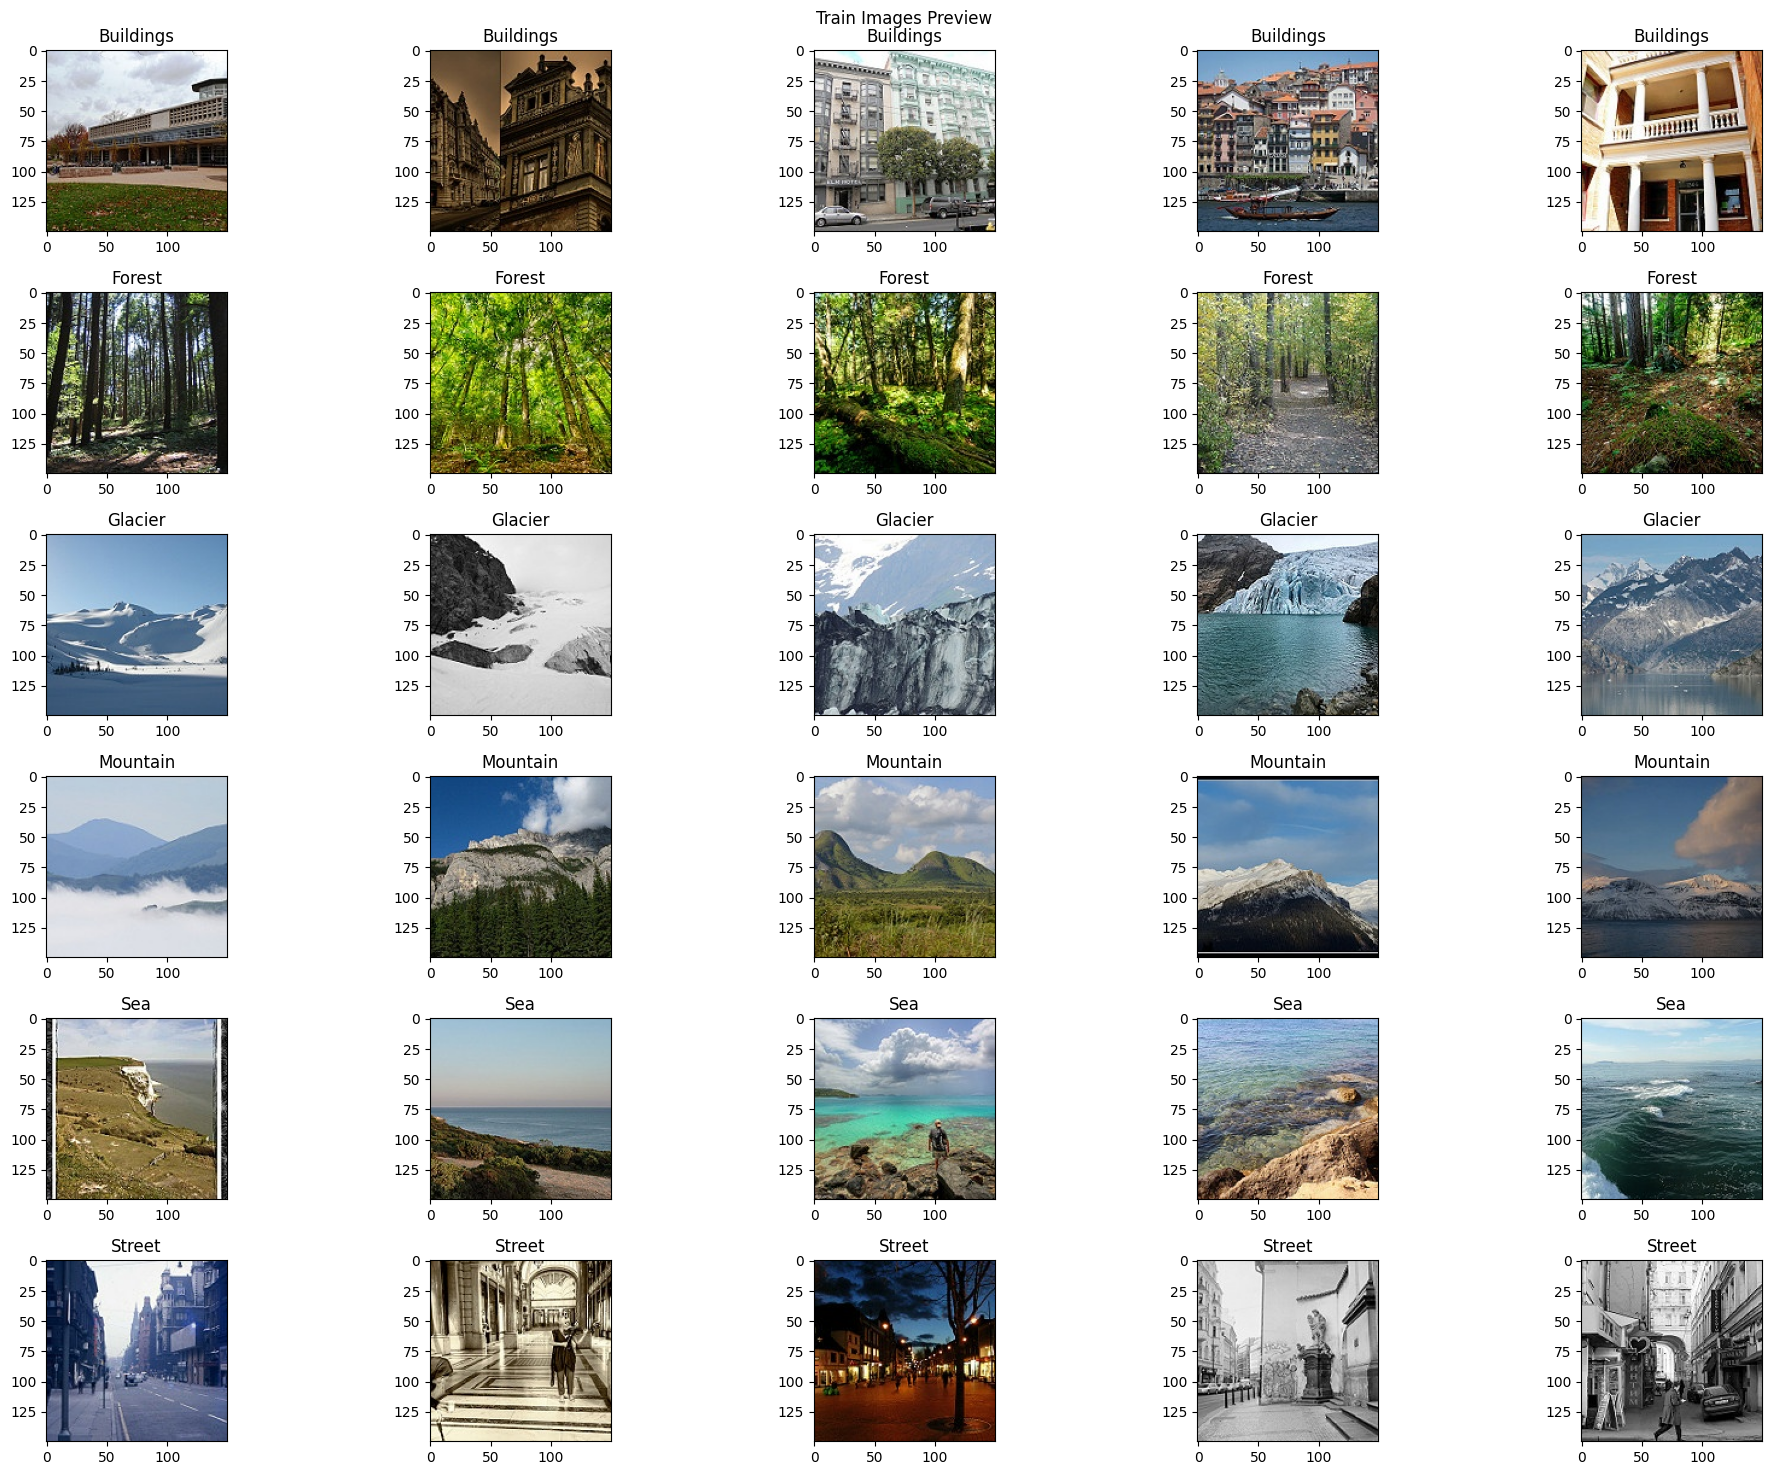

In [8]:
# Plot the images
plt.rcParams["figure.figsize"] = (20, 15)
fig, axs = plt.subplots(6, 5)

# Display images from each category
categories = ['Buildings', 'Forest', 'Glacier', 'Mountain', 'Sea', 'Street']

for i, (category, category_imgs) in enumerate(zip(categories, [buildings_img, forest_img, glacier_img, mountain_img, sea_img, street_img])):
    for j in range(5):
        axs[i, j].imshow(category_imgs[j])
        axs[i, j].axis('on')  # Use 'on' to hide axes
        axs[i, j].set_title(category)  # Add a title for each image in the column
        
plt.suptitle('Train Images Preview')
plt.tight_layout()
plt.show()

# **Data Loader 🔃**
---

In [9]:
def load_data():
    datasets = ['/kaggle/input/intel-image-classification/seg_train/seg_train', 
                '/kaggle/input/intel-image-classification/seg_test/seg_test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = Image.open(img_path)
                image = image.resize((150, 150))
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.stack(images, axis=0)
        labels = np.array(labels, dtype='int32')
   
        output.append((images, labels))

    return output

In [10]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading /kaggle/input/intel-image-classification/seg_train/seg_train


100%|██████████| 2404/2404 [00:13<00:00, 177.05it/s]


Loading /kaggle/input/intel-image-classification/seg_test/seg_test


100%|██████████| 553/553 [00:02<00:00, 193.78it/s]


In [11]:
train_images[0]

array([[[189, 203, 216],
        [189, 203, 216],
        [189, 203, 216],
        ...,
        [189, 201, 213],
        [189, 201, 213],
        [189, 201, 213]],

       [[191, 205, 218],
        [191, 205, 218],
        [191, 205, 218],
        ...,
        [189, 201, 213],
        [189, 201, 213],
        [189, 201, 213]],

       [[192, 206, 219],
        [192, 206, 219],
        [192, 206, 219],
        ...,
        [188, 200, 212],
        [188, 200, 212],
        [188, 200, 212]],

       ...,

       [[220, 223, 230],
        [219, 222, 229],
        [219, 222, 229],
        ...,
        [218, 221, 228],
        [218, 221, 228],
        [218, 221, 228]],

       [[220, 223, 230],
        [219, 222, 229],
        [219, 222, 229],
        ...,
        [218, 221, 228],
        [218, 221, 228],
        [218, 221, 228]],

       [[219, 222, 229],
        [219, 222, 229],
        [219, 222, 229],
        ...,
        [218, 221, 228],
        [218, 221, 228],
        [218, 221, 228]]

In [12]:
# Scale all the samples
train_images = train_images / 255.0 
test_images = test_images / 255.0

In [13]:
# Convert NumPy arrays to TensorFlow tensors
train_images_tensor = tf.convert_to_tensor(train_images, dtype=tf.float32)
train_labels_tensor = tf.convert_to_tensor(train_labels, dtype=tf.int32)
test_images_tensor = tf.convert_to_tensor(test_images, dtype=tf.float32)
test_labels_tensor = tf.convert_to_tensor(test_labels, dtype=tf.int32)

# Create a TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_images_tensor, train_labels_tensor))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images_tensor, test_labels_tensor))

# Set a buffer size for shuffling
buffer_size = 10000

# Shuffle the dataset
train_dataset = train_dataset.shuffle(buffer_size=buffer_size, seed=25)
test_dataset =  test_dataset.shuffle(buffer_size=buffer_size, seed=25)

# Now you can iterate over the shuffled dataset to train your model

In [14]:
train_labels_tensor

<tf.Tensor: shape=(14034,), dtype=int32, numpy=array([3, 3, 3, ..., 2, 2, 2], dtype=int32)>

In [15]:
def display_random_image(class_names, images, labels):
    index = np.random.randint(images.shape[0])
    plt.figure(figsize=(3,3))
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

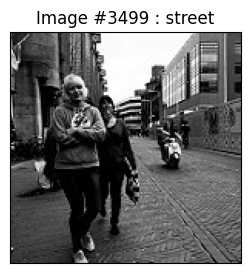

In [16]:
display_random_image(class_names, train_images_tensor, train_labels_tensor)

# **Exploratory Data Analysis 📊**
---

In [17]:
n_train = train_labels_tensor.shape[0]
n_test = test_labels_tensor.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))

Number of training examples: 14034
Number of testing examples: 3000


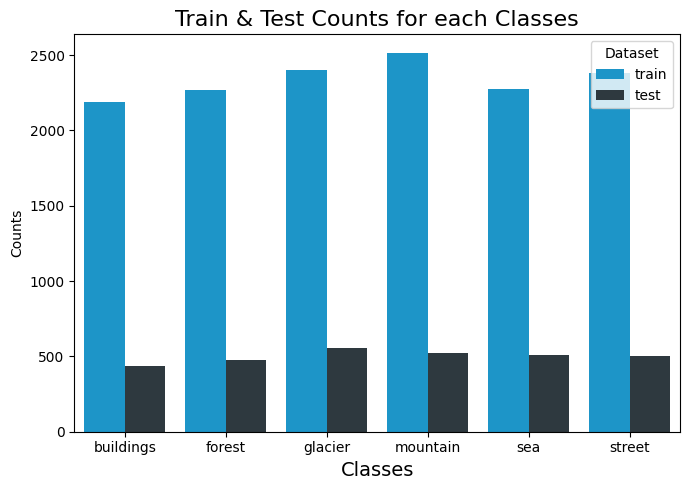

In [18]:
_, train_counts = np.unique(train_labels_tensor, return_counts=True)
_, test_counts = np.unique(test_labels_tensor, return_counts=True)

# Create a DataFrame
data = pd.DataFrame({'train': train_counts, 'test': test_counts}, index=class_names)

# Set a custom color palette
custom_palette = sns.color_palette(["#00A1E4", "#2B3A42"], len(class_names))

# Set the figure size
plt.figure(figsize=(7, 5))

# Melt the DataFrame for Seaborn
data_melted = data.reset_index().melt(id_vars='index', var_name='Dataset', value_name='Counts')

# Use Seaborn to create a bar plot with customizations
sns.barplot(x='index', y='Counts', hue='Dataset', data=data_melted, palette=custom_palette)

# Set x-axis labels and title
plt.xlabel('Classes', fontsize=14)
plt.title('Train & Test Counts for each Classes', fontsize=16)

# Add legend with adjusted font size
plt.legend(title='Dataset', fontsize='medium')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

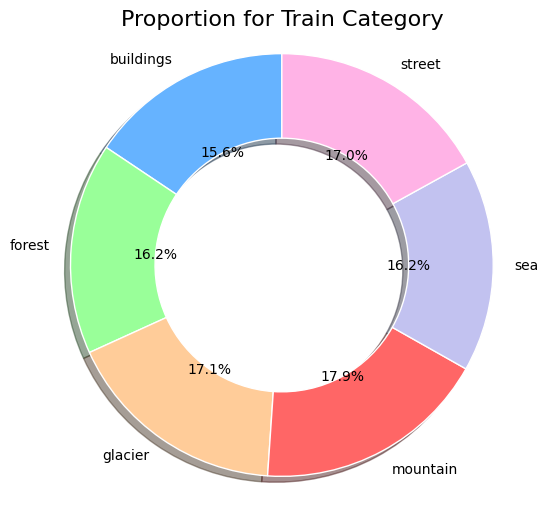

In [19]:
# Set custom colors for the pie chart
colors = ['#66b3ff', '#99ff99', '#ffcc99', '#ff6666', '#c2c2f0', '#ffb3e6']

# Create a pie chart with some modifications
plt.figure(figsize=(6, 6))
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0),
        labels=class_names,
        autopct='%1.1f%%',
        colors=colors,
        shadow=True,  # Add shadow for depth
        startangle=90,  # Start the chart at 90 degrees (top of the circle)
        wedgeprops=dict(width=0.4, edgecolor='w'))  # Adjust the width and edge color of wedges

# Set the title
plt.title('Proportion for Train Category', fontsize=16)

# Show the plot
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

# **Model Building 🤖**
---

In [20]:
model = Sequential([Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
                    MaxPool2D((2,2)),
                    Conv2D(32, (3,3), activation='relu'),
                    MaxPool2D((2,2)),
                    Flatten(),
                    Dense(128, activation='relu'),
                    Dropout(0.3),
                    Dense(6, activation='softmax')])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 dense (Dense)               (None, 128)               5

In [21]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

history = model.fit(train_images, 
                    train_labels, 
                    batch_size=128, 
                    epochs=20, 
                    validation_split = 0.2)

Epoch 1/20
88/88 [==============================] - 112s 1s/step - loss: 1.2319 - accuracy: 0.5508 - val_loss: 4.1743 - val_accuracy: 0.1265
Epoch 2/20
88/88 [==============================] - 104s 1s/step - loss: 0.7007 - accuracy: 0.7341 - val_loss: 6.5580 - val_accuracy: 0.1304
Epoch 3/20
88/88 [==============================] - 108s 1s/step - loss: 0.5775 - accuracy: 0.7856 - val_loss: 7.3662 - val_accuracy: 0.1357
Epoch 4/20
88/88 [==============================] - 105s 1s/step - loss: 0.4534 - accuracy: 0.8337 - val_loss: 8.3124 - val_accuracy: 0.1357
Epoch 5/20
88/88 [==============================] - 105s 1s/step - loss: 0.3670 - accuracy: 0.8651 - val_loss: 9.2258 - val_accuracy: 0.1325
Epoch 6/20
88/88 [==============================] - 120s 1s/step - loss: 0.3087 - accuracy: 0.8891 - val_loss: 8.9287 - val_accuracy: 0.1350
Epoch 7/20
88/88 [==============================] - 107s 1s/step - loss: 0.2551 - accuracy: 0.9076 - val_loss: 8.9109 - val_accuracy: 0.1340
Epoch 8/20
88

# **Model Evaluation 🕵🏻**
---

In [22]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

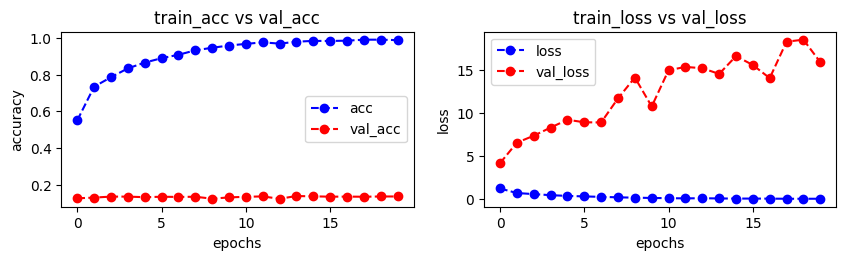

In [23]:
plot_accuracy_loss(history)

In [24]:
test_loss = model.evaluate(test_images, test_labels)

94/94 [==============================] - 10s 102ms/step - loss: 4.1389 - accuracy: 0.6740


94/94 [==============================] - 13s 137ms/step


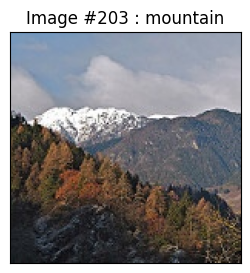

In [25]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, test_images, pred_labels)

# **Error Analysis 🔬**
---

In [26]:
def display_examples(class_names, images, labels):
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Examples of Images", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

In [27]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Examples of Mislabeled Images"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)

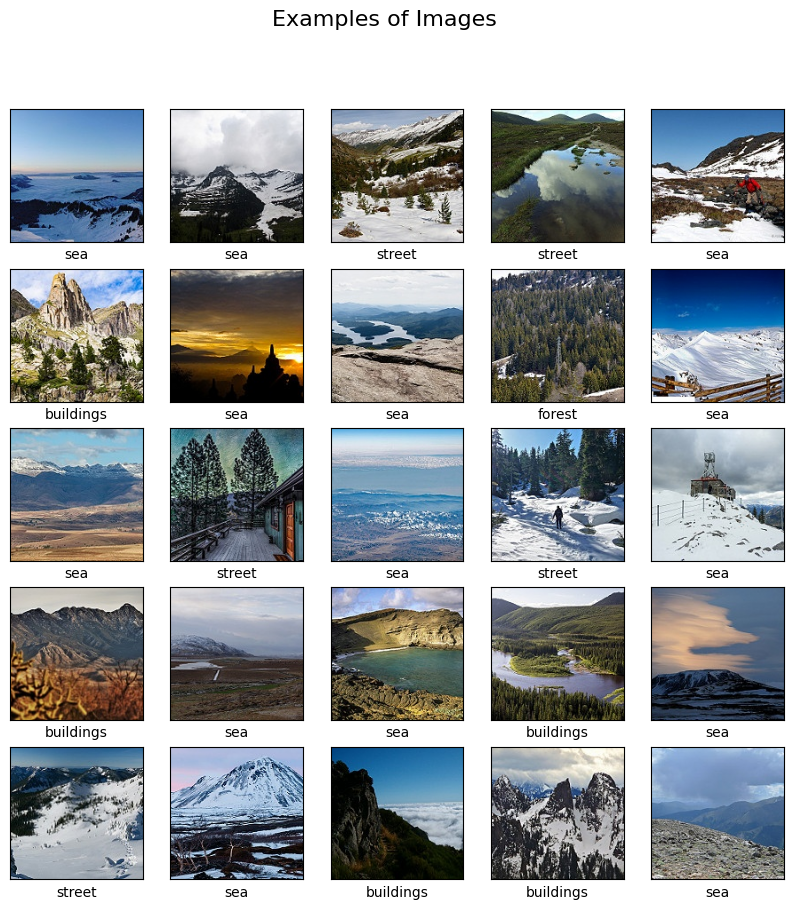

In [28]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

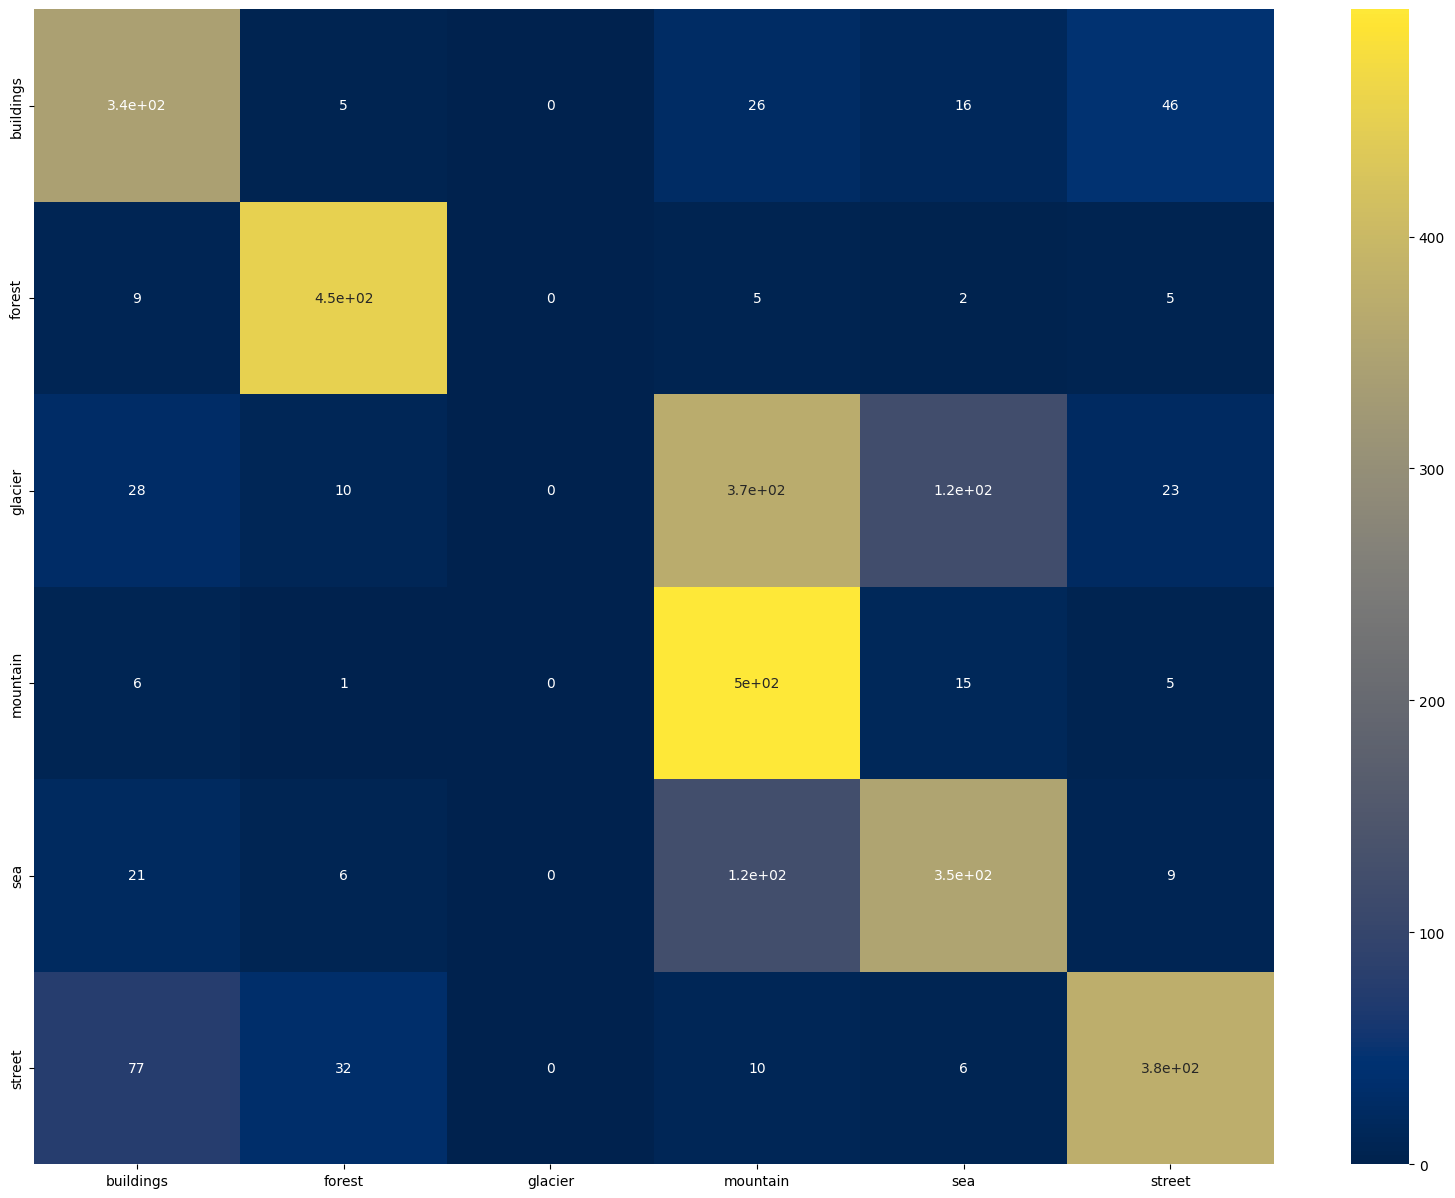

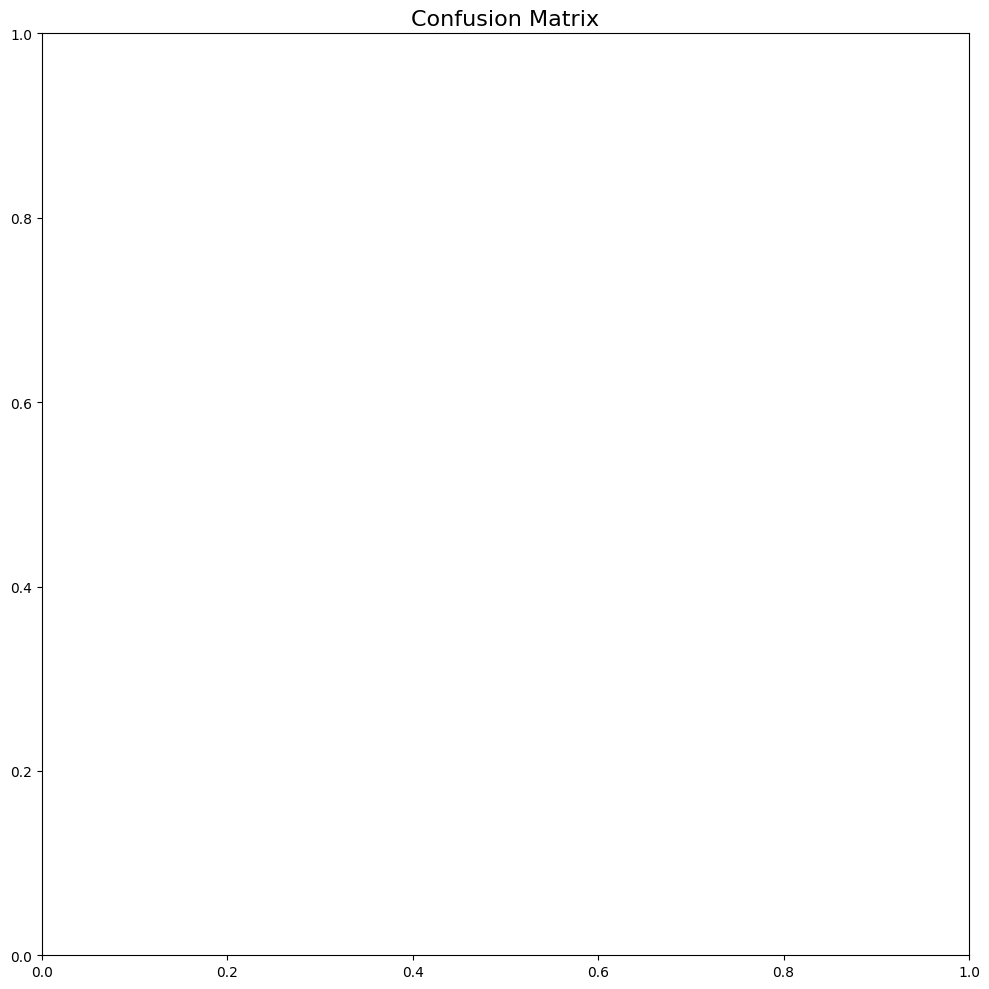

In [29]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
plt.figure(figsize=(10, 10))
sns.heatmap(CM, annot=True, cmap="cividis", 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
plt.title('Confusion Matrix', fontsize=16)
plt.tight_layout()
plt.show()

# **References**
---
* [Intel Image Classifications CNN Keras](https://www.kaggle.com/code/vincee/intel-image-classification-cnn-keras)
* [TensorFlow Image Classification Guide](https://www.kaggle.com/code/calebreigada/tensorflow-image-classification-guide)